In [1]:
#pip install keras-tqdm

In [2]:
import numpy as np
import pandas as pd
import cv2
import os
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import glob
import tensorflow as tf
from keras.models import Sequential
from keras.preprocessing.image import load_img
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras import layers
from keras.layers import *
from keras.utils import np_utils
from keras.preprocessing.image import ImageDataGenerator
import matplotlib.gridspec as gridspec
from keras_tqdm import TQDMNotebookCallback
from keras.callbacks import EarlyStopping, ModelCheckpoint

/opt/conda/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/opt/conda/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/opt/conda/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/opt/conda/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:519: FutureWarning: Passing (type, 1) or 

In [3]:
#ignore warnings in the output
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)

In [4]:
dataset_directory = "Plate_OCR_Dataset/"

image_height = 80
image_width = 80

batch_size = 4

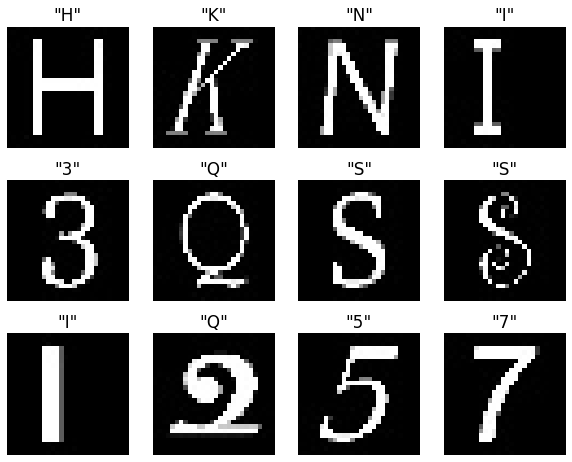

In [5]:
dataset_paths = glob.glob(dataset_directory+"**/*.jpg")

cols=4
rows=3
fig = plt.figure(figsize=(10,8))
plt.rcParams.update({"font.size":14})
grid = gridspec.GridSpec(ncols=cols,nrows=rows,figure=fig)

# create a random list of images will be displayed
np.random.seed(45)
rand = np.random.randint(0,len(dataset_paths),size=(cols*rows))

# Plot image
for i in range(cols*rows):
    fig.add_subplot(grid[i])
    image = load_img(dataset_paths[rand[i]])
    label = dataset_paths[rand[i]].split(os.path.sep)[-2]
    plt.title('"{:s}"'.format(label))
    plt.axis(False)
    plt.imshow(image)


In [6]:
model = Sequential()

model.add(Conv2D(filters = 64, kernel_size = (5,5),padding = 'Same', activation ='relu', input_shape = (image_height,image_width,3)))
model.add(BatchNormalization())

model.add(Conv2D(filters = 64, kernel_size = (5,5),padding = 'Same', activation ='relu'))
model.add(BatchNormalization())

model.add(MaxPool2D(pool_size=(2,2)))
model.add(Dropout(0.25))

model.add(Conv2D(filters = 64, kernel_size = (3,3),padding = 'Same', activation ='relu'))
model.add(BatchNormalization())

model.add(Conv2D(filters = 64, kernel_size = (3,3),padding = 'Same', activation ='relu'))
model.add(BatchNormalization())
model.add(MaxPool2D(pool_size=(2,2), strides=(2,2)))
model.add(Dropout(0.25))

model.add(Conv2D(filters = 64, kernel_size = (3,3), padding = 'Same',  activation ='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.25))


In [7]:
model.add(Flatten())
model.add(Dense(256, activation = "relu"))
model.add(BatchNormalization())
model.add(Dropout(0.25))

model.add(Dense(36, activation = "softmax"))

In [8]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 80, 80, 64)        4864      
_________________________________________________________________
batch_normalization_1 (Batch (None, 80, 80, 64)        256       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 80, 80, 64)        102464    
_________________________________________________________________
batch_normalization_2 (Batch (None, 80, 80, 64)        256       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 40, 40, 64)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 40, 40, 64)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 40, 40, 64)       

In [9]:
weights_directory = "Weights/"

optimizer_name = 'adam'

model.compile(loss='categorical_crossentropy', optimizer=optimizer_name, metrics=['accuracy'])

model_name = weights_directory+optimizer_name+"_OCR_Plate_Model"

early_stopping = EarlyStopping(monitor='val_loss', patience=5, verbose=1, mode='min')
mcp_save = ModelCheckpoint(model_name+'.h5', save_best_only=True, monitor='val_loss', verbose=1, mode='auto')

In [10]:
train_datagen = ImageDataGenerator(
        rescale=1./255,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True)

test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
        dataset_directory,  # this is the target directory
        target_size=(image_height, image_width), 
        batch_size=batch_size,
        class_mode='categorical')  

# this is a similar generator, for validation data
validation_generator = test_datagen.flow_from_directory(
        dataset_directory,
        target_size=(image_height, image_width),
        batch_size=batch_size,
        class_mode='categorical')


Found 37623 images belonging to 36 classes.
Found 37623 images belonging to 36 classes.


In [ ]:
model.fit_generator(
        train_generator,
        steps_per_epoch=800 // batch_size,
        epochs=50,
        validation_data=validation_generator,
        validation_steps=20 // batch_size,
        callbacks=[early_stopping, mcp_save, TQDMNotebookCallback()])


Epoch 1/50


200/200 [==============================] - 1202s 6s/step - loss: 3.3199 - acc: 0.1475 - val_loss: 4.3119 - val_acc: 0.2500

Epoch 00001: val_loss improved from inf to 4.31187, saving model to Weights/adam_OCR_Plate_Model.h5
Epoch 2/50


200/200 [==============================] - 1381s 7s/step - loss: 2.6291 - acc: 0.2950 - val_loss: 2.1679 - val_acc: 0.5500

Epoch 00002: val_loss improved from 4.31187 to 2.16790, saving model to Weights/adam_OCR_Plate_Model.h5
Epoch 3/50


200/200 [==============================] - 1105s 6s/step - loss: 2.3211 - acc: 0.3600 - val_loss: 1.8976 - val_acc: 0.4500

Epoch 00003: val_loss improved from 2.16790 to 1.89760, saving model to Weights/adam_OCR_Plate_Model.h5
Epoch 4/50


200/200 [==============================] - 982s 5s/step - loss: 2.3831 - acc: 0.3450 - val_loss: 1.8974 - val_acc: 0.6000

Epoch 00004: val_loss improved from 1.89760 to 1.89736, saving model to Weights/adam_OCR_Plate_Model.h5
Epoch 5/50


200/200 [==============================] - 956s 5s/step - loss: 2.1078 - acc: 0.4113 - val_loss: 1.0951 - val_acc: 0.6500

Epoch 00005: val_loss improved from 1.89736 to 1.09507, saving model to Weights/adam_OCR_Plate_Model.h5
Epoch 6/50


200/200 [==============================] - 957s 5s/step - loss: 2.0477 - acc: 0.4025 - val_loss: 1.5229 - val_acc: 0.6500

Epoch 00006: val_loss did not improve from 1.09507
Epoch 7/50


200/200 [==============================] - 926s 5s/step - loss: 1.9032 - acc: 0.4642 - val_loss: 1.8578 - val_acc: 0.5500

Epoch 00007: val_loss did not improve from 1.09507
Epoch 8/50


200/200 [==============================] - 979s 5s/step - loss: 1.8001 - acc: 0.5012 - val_loss: 1.1970 - val_acc: 0.6000

Epoch 00008: val_loss did not improve from 1.09507
Epoch 9/50


200/200 [==============================] - 808s 4s/step - loss: 1.7537 - acc: 0.5238 - val_loss: 1.0795 - val_acc: 0.6000

Epoch 00009: val_loss improved from 1.09507 to 1.07947, saving model to Weights/adam_OCR_Plate_Model.h5
Epoch 10/50


200/200 [==============================] - 810s 4s/step - loss: 1.8325 - acc: 0.5050 - val_loss: 2.0891 - val_acc: 0.3500

Epoch 00010: val_loss did not improve from 1.07947
Epoch 11/50


102/200 [==============>...............] - ETA: 6:28 - loss: 1.6331 - acc: 0.5613

In [ ]:
dataset_paths = glob.glob("Plate_OCR_Dataset/**/*.jpg")

In [ ]:
# Arange input data and corresponding labels
labels=[]

for image_path in dataset_paths:
    label = image_path.split(os.path.sep)[-2]
    labels.append(label)
labels = np.array(labels)

In [ ]:
# perform one-hot encoding on the labels
lb = LabelEncoder()
lb.fit(labels)
labels = lb.transform(labels)
y = to_categorical(labels)

# save label file so we can use in another script
np.save(weights_directory+'license_character_classes.npy', lb.classes_)